<a href="https://colab.research.google.com/github/Adil1979/P6_Tag_Recommendation_Stackoverflow/blob/master/01_P6_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet6: Catégorisation automatique de questions**

## **1.Librairies**

In [1]:
!pip install feature_engine


     |████████████████████████████████| 9.5MB 11.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
!pip install plotly

In [3]:
!pip install chart-studio

     |████████████████████████████████| 71kB 5.9MB/s 


In [4]:
!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import matplotlib as mpl
import chart_studio.plotly.plotly as py
from collections import Counter
#import plotly.plotly as py
import seaborn as sns
import datetime as dt
import calendar as cld
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from os import listdir
import glob
import missingno as msno
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from sklearn.decomposition import PCA
from matplotlib import dates
import nltk
import re
from nltk.corpus import stopwords 
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer 
import string
from collections import Counter
from bs4 import BeautifulSoup
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import Word2Vec #Word Embedding

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


SELECT Id, Body, Title, Tags

FROM Posts

WHERE Score >= 3 AND PostTypeId = 1

ORDER BY RAND()
 
ASC OFFSET 0 ROWS FETCH NEXT 50000 ROWS ONLY; de 0 à 50000

## **2.Data**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#df_analysis_01 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_01.csv')
#df_analysis_02 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_02.csv')
#df_analysis_03 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_03.csv')
#frames = [df_analysis_01, df_analysis_02, df_analysis_03]
#df_analysis = pd.concat(frames)
#df_sample = df_analysis.sample(n=40000)
#df_sample.to_csv('df_sample.csv')

In [9]:
df_sample = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/df_sample.csv')
df_sample = df_sample.drop(['Unnamed: 0'], axis=1)
df_sample.head()

,Id,Body,Title,Tags,CreationDate
0,48060830,<p>I am trying to create a very simple system ...,Create System Tray Icon from Webdings font,<c#><.net><windows><icons>,2018-01-02 12:15:37
1,57451083,"<p><a href=""http://eel.is/c++draft/basic.exec#...",Intent of [basic.execution] p5 sentence 2,<c++><language-lawyer><full-expression>,2019-08-11 14:59:51
2,56279423,<p>I use the MongoDB aggregation API to aggreg...,MongoDB: Reduce array of objects into a single...,<mongodb><mongodb-query><aggregation-framework>,2019-05-23 16:24:08
3,48326694,<p>I wonder if its possible to validate a arra...,Laravel validate array of objects,<laravel>,2018-01-18 17:03:31
4,58501086,<p>I am trying to load the save weights using ...,ValueError: Unknown activation function:swish_...,<python><tensorflow><keras><activation-function>,2019-10-22 09:25:59


In [10]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            40000 non-null  int64 
 1   Body          40000 non-null  object
 2   Title         40000 non-null  object
 3   Tags          40000 non-null  object
 4   CreationDate  40000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


In [11]:
df_sample = df_sample.loc[:, ['Id', 'Title', 'Body', 'Tags']]
df_sample = df_sample.set_index('Id').reset_index(drop=True)
df_sample.head()

,Title,Body,Tags
0,Create System Tray Icon from Webdings font,<p>I am trying to create a very simple system ...,<c#><.net><windows><icons>
1,Intent of [basic.execution] p5 sentence 2,"<p><a href=""http://eel.is/c++draft/basic.exec#...",<c++><language-lawyer><full-expression>
2,MongoDB: Reduce array of objects into a single...,<p>I use the MongoDB aggregation API to aggreg...,<mongodb><mongodb-query><aggregation-framework>
3,Laravel validate array of objects,<p>I wonder if its possible to validate a arra...,<laravel>
4,ValueError: Unknown activation function:swish_...,<p>I am trying to load the save weights using ...,<python><tensorflow><keras><activation-function>


## **3.Preprocessing**

In [12]:
df_sample.duplicated(subset=["Body", "Title"]).sum()

0

In [13]:
example_body = df_sample.Body.iloc[0]

In [14]:
example_body

'<p>I am trying to create a very simple system tray icon that is nothing but a dynamically colored circle with a white border.  To do that, we are using the Webdings font.  "n" in Webdings is just a plain circle.</p>\n\n<p>What I\'m currently doing is almost there, but on some PC\'s (yet not all) it ends up having a choppy, ugly black border around it:</p>\n\n<p><a href="https://i.stack.imgur.com/2rwwx.png" rel="nofollow noreferrer"><img src="https://i.stack.imgur.com/2rwwx.png" alt="enter image description here"></a></p>\n\n<p>Here\'s what I\'ve got:</p>\n\n<pre><code>protected static Icon GetTrayIconFromCache(Color statusColor)\n{\n    Bitmap bmp = new Bitmap(16,16);                            \n    Graphics circleGraphic = Graphics.FromImage(bmp);\n    circleGraphic.DrawString("n", new Font("Webdings", 12F, FontStyle.Regular), Brushes.White, -3f, -2f);\n    circleGraphic.DrawString("n", new Font("Webdings", 9F, FontStyle.Regular), new SolidBrush(statusColor), 0f, -1f);\n    Icon ico

In [15]:
example_title = df_sample.Title.iloc[0]

In [16]:
example_title

'Create System Tray Icon from Webdings font'

In [17]:
#Merge Title and Body
df_sample['Title_Body'] = df_sample['Title'] + ' ' + df_sample['Body']

In [18]:
df_sample.head()


,Title,Body,Tags,Title_Body
0,Create System Tray Icon from Webdings font,<p>I am trying to create a very simple system ...,<c#><.net><windows><icons>,Create System Tray Icon from Webdings font <p>...
1,Intent of [basic.execution] p5 sentence 2,"<p><a href=""http://eel.is/c++draft/basic.exec#...",<c++><language-lawyer><full-expression>,Intent of [basic.execution] p5 sentence 2 <p><...
2,MongoDB: Reduce array of objects into a single...,<p>I use the MongoDB aggregation API to aggreg...,<mongodb><mongodb-query><aggregation-framework>,MongoDB: Reduce array of objects into a single...
3,Laravel validate array of objects,<p>I wonder if its possible to validate a arra...,<laravel>,Laravel validate array of objects <p>I wonder ...
4,ValueError: Unknown activation function:swish_...,<p>I am trying to load the save weights using ...,<python><tensorflow><keras><activation-function>,ValueError: Unknown activation function:swish_...


In [19]:
variables_reorganization = ['Title_Body', 'Tags']
df_sample = df_sample[['Title_Body', 'Tags']]

In [20]:
df_sample.head()

,Title_Body,Tags
0,Create System Tray Icon from Webdings font <p>...,<c#><.net><windows><icons>
1,Intent of [basic.execution] p5 sentence 2 <p><...,<c++><language-lawyer><full-expression>
2,MongoDB: Reduce array of objects into a single...,<mongodb><mongodb-query><aggregation-framework>
3,Laravel validate array of objects <p>I wonder ...,<laravel>
4,ValueError: Unknown activation function:swish_...,<python><tensorflow><keras><activation-function>


In [21]:
df_sample.Title_Body.iloc[0]

'Create System Tray Icon from Webdings font <p>I am trying to create a very simple system tray icon that is nothing but a dynamically colored circle with a white border.  To do that, we are using the Webdings font.  "n" in Webdings is just a plain circle.</p>\n\n<p>What I\'m currently doing is almost there, but on some PC\'s (yet not all) it ends up having a choppy, ugly black border around it:</p>\n\n<p><a href="https://i.stack.imgur.com/2rwwx.png" rel="nofollow noreferrer"><img src="https://i.stack.imgur.com/2rwwx.png" alt="enter image description here"></a></p>\n\n<p>Here\'s what I\'ve got:</p>\n\n<pre><code>protected static Icon GetTrayIconFromCache(Color statusColor)\n{\n    Bitmap bmp = new Bitmap(16,16);                            \n    Graphics circleGraphic = Graphics.FromImage(bmp);\n    circleGraphic.DrawString("n", new Font("Webdings", 12F, FontStyle.Regular), Brushes.White, -3f, -2f);\n    circleGraphic.DrawString("n", new Font("Webdings", 9F, FontStyle.Regular), new Solid

### **HTML**

In [22]:
#HTML characters removing
def remove_html(body):
  html_regex = re.compile('<.*?>') #Compile regular expresions
  return re.sub(html_regex, ' ', str(body)) # Replace regex by ' '

In [23]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_html)
df_sample.head()

,Title_Body,Tags
0,Create System Tray Icon from Webdings font I ...,<c#><.net><windows><icons>
1,Intent of [basic.execution] p5 sentence 2 [b...,<c++><language-lawyer><full-expression>
2,MongoDB: Reduce array of objects into a single...,<mongodb><mongodb-query><aggregation-framework>
3,Laravel validate array of objects I wonder if...,<laravel>
4,ValueError: Unknown activation function:swish_...,<python><tensorflow><keras><activation-function>


In [24]:
df_sample.Title_Body.iloc[0]

'Create System Tray Icon from Webdings font  I am trying to create a very simple system tray icon that is nothing but a dynamically colored circle with a white border.  To do that, we are using the Webdings font.  "n" in Webdings is just a plain circle. \n\n What I\'m currently doing is almost there, but on some PC\'s (yet not all) it ends up having a choppy, ugly black border around it: \n\n     \n\n Here\'s what I\'ve got: \n\n  protected static Icon GetTrayIconFromCache(Color statusColor)\n{\n    Bitmap bmp = new Bitmap(16,16);                            \n    Graphics circleGraphic = Graphics.FromImage(bmp);\n    circleGraphic.DrawString("n", new Font("Webdings", 12F, FontStyle.Regular), Brushes.White, -3f, -2f);\n    circleGraphic.DrawString("n", new Font("Webdings", 9F, FontStyle.Regular), new SolidBrush(statusColor), 0f, -1f);\n    Icon ico = Icon.FromHandle((bmp).GetHicon());\n    return ico;\n}\n  \n\n No matter what I try, I can\'t get rid of those ugly black dots around the 

### **URL**

In [25]:
#URL removing
def remove_url(body):
  url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
  return re.sub(url_regex, ' ', str(body))  

In [26]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_url)
df_sample.head()

,Title_Body,Tags
0,Create System Tray Icon from Webdings font I ...,<c#><.net><windows><icons>
1,Intent of [basic.execution] p5 sentence 2 [b...,<c++><language-lawyer><full-expression>
2,MongoDB: Reduce array of objects into a single...,<mongodb><mongodb-query><aggregation-framework>
3,Laravel validate array of objects I wonder if...,<laravel>
4,ValueError: Unknown activation function:swish_...,<python><tensorflow><keras><activation-function>


In [27]:
df_sample.Title_Body.iloc[0]

'Create System Tray Icon from Webdings font  I am trying to create a very simple system tray icon that is nothing but a dynamically colored circle with a white border.  To do that, we are using the Webdings font.  "n" in Webdings is just a plain circle. \n\n What I\'m currently doing is almost there, but on some PC\'s (yet not all) it ends up having a choppy, ugly black border around it: \n\n     \n\n Here\'s what I\'ve got: \n\n  protected static Icon GetTrayIconFromCache(Color statusColor)\n{\n    Bitmap bmp = new Bitmap(16,16);                            \n    Graphics circleGraphic = Graphics.FromImage(bmp);\n    circleGraphic.DrawString("n", new Font("Webdings", 12F, FontStyle.Regular), Brushes.White, -3f, -2f);\n    circleGraphic.DrawString("n", new Font("Webdings", 9F, FontStyle.Regular), new SolidBrush(statusColor), 0f, -1f);\n    Icon ico = Icon.FromHandle((bmp).GetHicon());\n    return ico;\n}\n  \n\n No matter what I try, I can\'t get rid of those ugly black dots around the 

### **Punctuation**

In [28]:
#Punctuation removing
def remove_punc(body):
  clean_text = re.sub(r'[?|!|"|:|=|_|{|}|[|]|-|$|%|^|&|]',r' ',str(body))
  clean_text = re.sub(r'[.|,|)|(|\|/|-|~|`|>|<|*|$|@|;|→]',r' ', clean_text)
  return clean_text

In [29]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_punc)

In [30]:
df_sample.Title_Body.iloc[0]

" Create System Tray Icon from Webdings font  I am trying to create a very simple system tray icon that is nothing but a dynamically colored circle with a white border   To do that  we are using the Webdings font    n  in Webdings is just a plain circle  \n\n What I'm currently doing is almost there  but on some PC's  yet not all  it ends up having a choppy  ugly black border around it  \n\n     \n\n Here's what I've got  \n\n  protected static Icon GetTrayIconFromCache Color statusColor \n \n    Bitmap bmp   new Bitmap 16 16                              \n    Graphics circleGraphic   Graphics FromImage bmp  \n    circleGraphic DrawString  n   new Font  Webdings   12F  FontStyle Regular   Brushes White   3f   2f  \n    circleGraphic DrawString  n   new Font  Webdings   9F  FontStyle Regular   new SolidBrush statusColor   0f   1f  \n    Icon ico   Icon FromHandle  bmp  GetHicon    \n    return ico \n \n  \n\n No matter what I try  I can't get rid of those ugly black dots around the outs

### **Other characters**

In [31]:
#All characters removing except letters, numbers 
#Lower
def remove_other(body):
  text = str(body)
  clean_text = re.sub(r"[^a-zA-Z0-9#+-]", " ", text.lower())
  return clean_text

In [32]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_other)
df_sample.head()

,Title_Body,Tags
0,create system tray icon from webdings font i...,<c#><.net><windows><icons>
1,intent of basic execution p5 sentence 2 ...,<c++><language-lawyer><full-expression>
2,mongodb reduce array of objects into a singl...,<mongodb><mongodb-query><aggregation-framework>
3,laravel validate array of objects i wonder i...,<laravel>
4,valueerror unknown activation function swish...,<python><tensorflow><keras><activation-function>


In [33]:
df_sample.Title_Body.iloc[0]

' create system tray icon from webdings font  i am trying to create a very simple system tray icon that is nothing but a dynamically colored circle with a white border   to do that  we are using the webdings font    n  in webdings is just a plain circle     what i m currently doing is almost there  but on some pc s  yet not all  it ends up having a choppy  ugly black border around it            here s what i ve got      protected static icon gettrayiconfromcache color statuscolor        bitmap bmp   new bitmap 16 16                                   graphics circlegraphic   graphics fromimage bmp       circlegraphic drawstring  n   new font  webdings   12f  fontstyle regular   brushes white   3f   2f       circlegraphic drawstring  n   new font  webdings   9f  fontstyle regular   new solidbrush statuscolor   0f   1f       icon ico   icon fromhandle  bmp  gethicon         return ico         no matter what i try  i can t get rid of those ugly black dots around the outside of the circle  

### **Space**

In [34]:
#Space removing
def remove_space(body):
  return ' '.join(str(body).split()) 

In [35]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_space)

In [36]:
df_sample.Title_Body.iloc[0]

'create system tray icon from webdings font i am trying to create a very simple system tray icon that is nothing but a dynamically colored circle with a white border to do that we are using the webdings font n in webdings is just a plain circle what i m currently doing is almost there but on some pc s yet not all it ends up having a choppy ugly black border around it here s what i ve got protected static icon gettrayiconfromcache color statuscolor bitmap bmp new bitmap 16 16 graphics circlegraphic graphics fromimage bmp circlegraphic drawstring n new font webdings 12f fontstyle regular brushes white 3f 2f circlegraphic drawstring n new font webdings 9f fontstyle regular new solidbrush statuscolor 0f 1f icon ico icon fromhandle bmp gethicon return ico no matter what i try i can t get rid of those ugly black dots around the outside of the circle they don t show up for everyone some of the developers don t see it and it looks crisp and clean we ve not yet figured out what the commonality 

In [37]:
#df_analysis['Title_Body_count'] = df_analysis['Title_Body'].apply(lambda text: len(text.split(" ")))

In [38]:
df_sample.head()

,Title_Body,Tags
0,create system tray icon from webdings font i a...,<c#><.net><windows><icons>
1,intent of basic execution p5 sentence 2 basic ...,<c++><language-lawyer><full-expression>
2,mongodb reduce array of objects into a single ...,<mongodb><mongodb-query><aggregation-framework>
3,laravel validate array of objects i wonder if ...,<laravel>
4,valueerror unknown activation function swish a...,<python><tensorflow><keras><activation-function>


### **StopWords**

In [39]:
#Tokenization
#nltk.download("punkt")
#from nltk.tokenize import word_tokenize

In [40]:
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import EnglishStemmer
lemma = WordNetLemmatizer().lemmatize
ps = PorterStemmer()
stemmer = EnglishStemmer()

In [41]:
set_alpha = set(['a', 'b', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 's', 't', 'u', 'v', 'w', 'x', 'y' 'z'])

In [42]:
def remove_stopwords(text):
    text = str(text)
    text = " ".join(word for word in text.split() if word not in gensim.parsing.preprocessing.STOPWORDS and word not in stop_words and word not in set_alpha )
    return text

In [43]:
df_sample['Title_Body'] = df_sample['Title_Body'].apply(remove_stopwords)

In [44]:
df_sample.Title_Body.iloc[0]

'create tray icon webdings font trying create simple tray icon dynamically colored circle white border webdings font webdings plain circle currently pc ends choppy ugly black border got protected static icon gettrayiconfromcache color statuscolor bitmap bmp new bitmap 16 16 graphics circlegraphic graphics fromimage bmp circlegraphic drawstring new font webdings 12f fontstyle regular brushes white 3f 2f circlegraphic drawstring new font webdings 9f fontstyle regular new solidbrush statuscolor 0f 1f icon ico icon fromhandle bmp gethicon return ico matter try rid ugly black dots outside circle developers looks crisp clean figured commonality pc looks good better way'

In [45]:
df_sample.head()

,Title_Body,Tags
0,create tray icon webdings font trying create s...,<c#><.net><windows><icons>
1,intent basic execution p5 sentence 2 basic exe...,<c++><language-lawyer><full-expression>
2,mongodb reduce array objects single object com...,<mongodb><mongodb-query><aggregation-framework>
3,laravel validate array objects wonder possible...,<laravel>
4,valueerror unknown activation function swish a...,<python><tensorflow><keras><activation-function>


## **Tokenization**

### **Question**

In [46]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [47]:
def tokenize(document):
  tokens = [lemma(w) for w in document.split() if w.isalpha()]
  return tokens

In [48]:
df_sample['Title_Body_Tokens'] = df_sample['Title_Body'].apply(tokenize)

In [49]:
df_sample.head()

,Title_Body,Tags,Title_Body_Tokens
0,create tray icon webdings font trying create s...,<c#><.net><windows><icons>,"[create, tray, icon, webdings, font, trying, c..."
1,intent basic execution p5 sentence 2 basic exe...,<c++><language-lawyer><full-expression>,"[intent, basic, execution, sentence, basic, ex..."
2,mongodb reduce array objects single object com...,<mongodb><mongodb-query><aggregation-framework>,"[mongodb, reduce, array, object, single, objec..."
3,laravel validate array objects wonder possible...,<laravel>,"[laravel, validate, array, object, wonder, pos..."
4,valueerror unknown activation function swish a...,<python><tensorflow><keras><activation-function>,"[valueerror, unknown, activation, function, sw..."


## **Tags**

In [50]:
from ast import literal_eval

In [51]:
df_sample.Tags.iloc[0]

'<c#><.net><windows><icons>'

In [52]:
# convert data to list
to_list = {'><': "','",'<':"['", '>':"']"}
for key, value in to_list.items():
  df_sample['Tags'] = df_sample['Tags'].str.replace(key, value)

In [53]:
df_sample_tok = df_sample
df_sample_tok.head()

,Title_Body,Tags,Title_Body_Tokens
0,create tray icon webdings font trying create s...,"['c#','.net','windows','icons']","[create, tray, icon, webdings, font, trying, c..."
1,intent basic execution p5 sentence 2 basic exe...,"['c++','language-lawyer','full-expression']","[intent, basic, execution, sentence, basic, ex..."
2,mongodb reduce array objects single object com...,"['mongodb','mongodb-query','aggregation-framew...","[mongodb, reduce, array, object, single, objec..."
3,laravel validate array objects wonder possible...,['laravel'],"[laravel, validate, array, object, wonder, pos..."
4,valueerror unknown activation function swish a...,"['python','tensorflow','keras','activation-fun...","[valueerror, unknown, activation, function, sw..."


In [55]:
def to_list(df,column):
  df[column] = df[column].apply(literal_eval)
  return df

In [56]:
df_sample_list = to_list(df_sample_tok, 'Tags')

In [57]:
reorganization = ['Title_Body', 'Title_Body_Tokens', 'Tags']
df_sample_list = df_sample_list[reorganization]
df_sample_list.head()


,Title_Body,Title_Body_Tokens,Tags
0,create tray icon webdings font trying create s...,"[create, tray, icon, webdings, font, trying, c...","[c#, .net, windows, icons]"
1,intent basic execution p5 sentence 2 basic exe...,"[intent, basic, execution, sentence, basic, ex...","[c++, language-lawyer, full-expression]"
2,mongodb reduce array objects single object com...,"[mongodb, reduce, array, object, single, objec...","[mongodb, mongodb-query, aggregation-framework]"
3,laravel validate array objects wonder possible...,"[laravel, validate, array, object, wonder, pos...",[laravel]
4,valueerror unknown activation function swish a...,"[valueerror, unknown, activation, function, sw...","[python, tensorflow, keras, activation-function]"


In [58]:
tags0 = df_sample_list['Tags']
question0 = df_sample_list['Title_Body_Tokens']

In [98]:
tags0.to_csv('tags0.csv')

In [60]:
tag_count = nltk.Counter()
for bloc in tags0:
  tag_count.update([word for word in bloc])
print(len(tag_count))
tag_500 = tag_count.most_common(500)
tag_500

12599


[('python', 5546),
 ('javascript', 3938),
 ('java', 2863),
 ('android', 2470),
 ('c#', 1987),
 ('c++', 1873),
 ('reactjs', 1544),
 ('angular', 1473),
 ('r', 1326),
 ('python-3.x', 1245),
 ('html', 1149),
 ('pandas', 1139),
 ('ios', 1137),
 ('node.js', 1089),
 ('swift', 963),
 ('typescript', 960),
 ('css', 942),
 ('php', 913),
 ('flutter', 818),
 ('docker', 708),
 ('c', 634),
 ('react-native', 633),
 ('firebase', 596),
 ('arrays', 576),
 ('kotlin', 562),
 ('amazon-web-services', 541),
 ('spring-boot', 523),
 ('tensorflow', 507),
 ('vue.js', 483),
 ('django', 483),
 ('sql', 469),
 ('dataframe', 456),
 ('dart', 455),
 ('numpy', 454),
 ('jquery', 450),
 ('laravel', 448),
 ('spring', 444),
 ('asp.net-core', 439),
 ('json', 398),
 ('git', 383),
 ('regex', 378),
 ('mysql', 372),
 ('.net', 346),
 ('xcode', 335),
 ('sql-server', 316),
 ('kubernetes', 315),
 ('haskell', 315),
 ('keras', 313),
 ('visual-studio-code', 309),
 ('scala', 308),
 ('string', 304),
 ('azure', 294),
 ('android-studio', 28

In [61]:
most_common_tags = [i for i, j in tag_count.items() if j > 31]
len(most_common_tags)

509

In [62]:
from collections import defaultdict

dict_tag_500 = defaultdict(int)
for x in tag_500:
    dict_tag_500[x[0]] += x[1]
dict_tag_500

defaultdict(int,
            {'.net': 346,
             '.net-core': 283,
             'aggregation-framework': 34,
             'airflow': 62,
             'ajax': 81,
             'algorithm': 277,
             'amazon-cloudformation': 58,
             'amazon-cognito': 40,
             'amazon-dynamodb': 41,
             'amazon-ec2': 66,
             'amazon-s3': 134,
             'amazon-web-services': 541,
             'anaconda': 87,
             'android': 2470,
             'android-architecture-components': 52,
             'android-constraintlayout': 34,
             'android-fragments': 65,
             'android-gradle-plugin': 98,
             'android-jetpack': 48,
             'android-layout': 74,
             'android-livedata': 36,
             'android-recyclerview': 83,
             'android-room': 50,
             'android-studio': 288,
             'androidx': 41,
             'angular': 1473,
             'angular-cli': 56,
             'angular-material': 126,
 

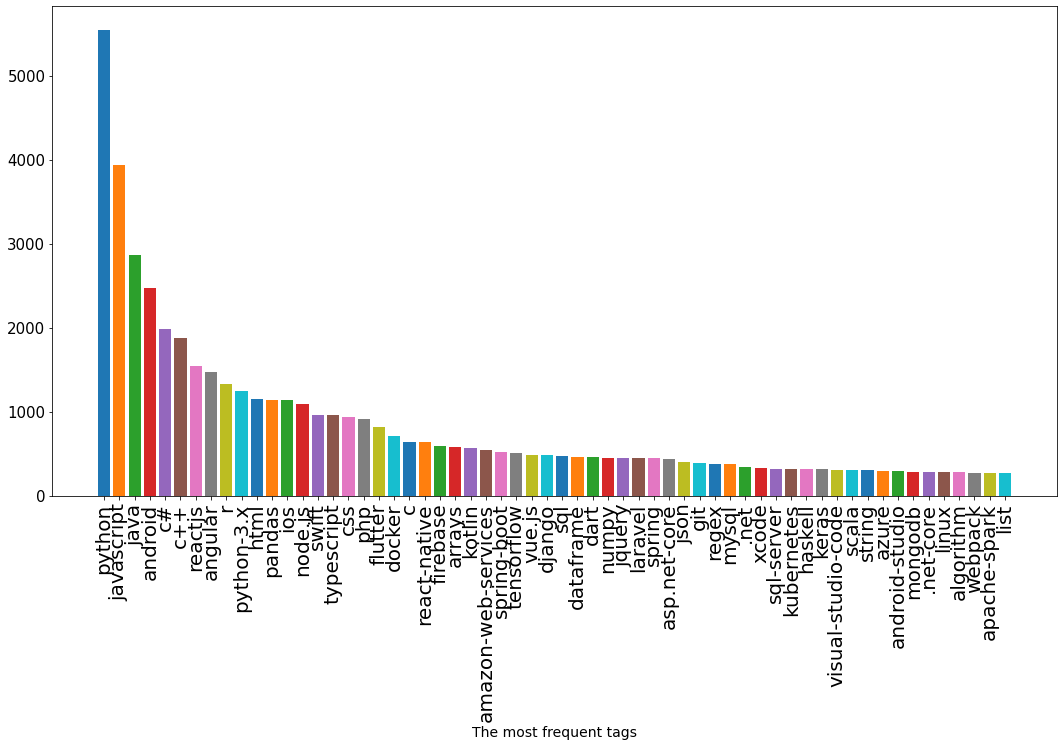

In [63]:
fig, ax = plt.subplots(figsize=(18, 9))


ax.set_xlabel('The most frequent tags', fontsize=14)
ax.bar(x=np.arange(60), 
       height=[x[1] for x in tag_count.most_common(60)],
       tick_label=[x[0] for x in tag_count.most_common(60)],
       color=plt.cm.get_cmap('tab10').colors)

plt.yticks(size=15)
plt.xticks(rotation='vertical', size=20)
plt.show()

In [64]:
def ListeToString(s):
  str1 = " "
  return (str1.join(s))

In [65]:
df_sample_list['Tag_st'] = df_sample_list['Tags'].apply(ListeToString)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [67]:
df_sample_list.head()

,Title_Body,Title_Body_Tokens,Tags,Tag_st
0,create tray icon webdings font trying create s...,"[create, tray, icon, webdings, font, trying, c...","[c#, .net, windows, icons]",c# .net windows icons
1,intent basic execution p5 sentence 2 basic exe...,"[intent, basic, execution, sentence, basic, ex...","[c++, language-lawyer, full-expression]",c++ language-lawyer full-expression
2,mongodb reduce array objects single object com...,"[mongodb, reduce, array, object, single, objec...","[mongodb, mongodb-query, aggregation-framework]",mongodb mongodb-query aggregation-framework
3,laravel validate array objects wonder possible...,"[laravel, validate, array, object, wonder, pos...",[laravel],laravel
4,valueerror unknown activation function swish a...,"[valueerror, unknown, activation, function, sw...","[python, tensorflow, keras, activation-function]",python tensorflow keras activation-function


In [68]:
df_sample_list_st = df_sample_list[['Title_Body', 'Tag_st', 'Title_Body_Tokens', 'Tags']]
df_sample_list_st.head()

,Title_Body,Tag_st,Title_Body_Tokens,Tags
0,create tray icon webdings font trying create s...,c# .net windows icons,"[create, tray, icon, webdings, font, trying, c...","[c#, .net, windows, icons]"
1,intent basic execution p5 sentence 2 basic exe...,c++ language-lawyer full-expression,"[intent, basic, execution, sentence, basic, ex...","[c++, language-lawyer, full-expression]"
2,mongodb reduce array objects single object com...,mongodb mongodb-query aggregation-framework,"[mongodb, reduce, array, object, single, objec...","[mongodb, mongodb-query, aggregation-framework]"
3,laravel validate array objects wonder possible...,laravel,"[laravel, validate, array, object, wonder, pos...",[laravel]
4,valueerror unknown activation function swish a...,python tensorflow keras activation-function,"[valueerror, unknown, activation, function, sw...","[python, tensorflow, keras, activation-function]"


In [69]:
tags1 = df_sample_list_st['Tag_st']
questions1  = df_sample_list_st['Title_Body']

In [70]:
tags1

0                              c# .net windows icons
1                c++ language-lawyer full-expression
2        mongodb mongodb-query aggregation-framework
3                                            laravel
4        python tensorflow keras activation-function
                            ...                     
39995                   java multithreading for-loop
39996               python .net dll nuget python.net
39997                     angular typescript jasmine
39998                                         python
39999                    android android-databinding
Name: Tag_st, Length: 40000, dtype: object

In [71]:
questions1.head()

0    create tray icon webdings font trying create s...
1    intent basic execution p5 sentence 2 basic exe...
2    mongodb reduce array objects single object com...
3    laravel validate array objects wonder possible...
4    valueerror unknown activation function swish a...
Name: Title_Body, dtype: object

## **TF-IDF**

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [73]:
list_tag_key_500 = set(dict_tag_500.keys())
list_tag_key_500

{'.net',
 '.net-core',
 'aggregation-framework',
 'airflow',
 'ajax',
 'algorithm',
 'amazon-cloudformation',
 'amazon-cognito',
 'amazon-dynamodb',
 'amazon-ec2',
 'amazon-s3',
 'amazon-web-services',
 'anaconda',
 'android',
 'android-architecture-components',
 'android-constraintlayout',
 'android-fragments',
 'android-gradle-plugin',
 'android-jetpack',
 'android-layout',
 'android-livedata',
 'android-recyclerview',
 'android-room',
 'android-studio',
 'androidx',
 'angular',
 'angular-cli',
 'angular-material',
 'angular-material2',
 'angular5',
 'angular6',
 'angular7',
 'angularjs',
 'animation',
 'annotations',
 'ansible',
 'apache',
 'apache-kafka',
 'apache-spark',
 'apache-spark-sql',
 'api',
 'apollo',
 'arkit',
 'arm',
 'arraylist',
 'arrays',
 'asp.net',
 'asp.net-core',
 'asp.net-core-2.0',
 'asp.net-core-2.1',
 'asp.net-core-mvc',
 'asp.net-core-webapi',
 'asp.net-mvc',
 'asp.net-web-api',
 'assembly',
 'async-await',
 'asynchronous',
 'audio',
 'authentication',
 'aut

In [74]:
def keep_tags(text):
    text = str(text)
    text = " ".join(tag for tag in text.split() if tag in list_tag_key_500  )
    return text

In [75]:
questions1 = questions1.apply(keep_tags)
questions1

0                                                   static
1                                 function function struct
2        mongodb object mongodb api date mongodb object...
3        laravel laravel post post text post post text ...
4        function keras keras input module keras keras ...
                               ...                        
39995                               multithreading c c c++
39996    class python class python nuget r c module ass...
39997    angular jasmine testing jasmine testing jasmin...
39998            object python class object c c c c object
39999    class static list string static class static c...
Name: Title_Body, Length: 40000, dtype: object

In [76]:
vectorizer = TfidfVectorizer(tokenizer = tokenize, stop_words = stop_words, max_features=500)
X_tfidf = vectorizer.fit_transform(questions1).toarray()
#X_train_tfidf = vectorizer.fit_transform(X_train).toarray() 
#X_test_tfidf = vectorizer.fit_transform(X_test).toarray()
#print('Total words: ', len(vectorizer.vocabulary))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [77]:
print(X_tfidf.shape)

(40000, 302)


In [78]:
print(vectorizer.get_feature_names())

['airflow', 'ajax', 'algorithm', 'anaconda', 'android', 'androidx', 'angular', 'angularjs', 'animation', 'annotation', 'ansible', 'apache', 'api', 'apollo', 'arkit', 'arm', 'array', 'arraylist', 'assembly', 'asynchronous', 'audio', 'authentication', 'awk', 'axios', 'azure', 'bash', 'beautifulsoup', 'blazor', 'boost', 'browser', 'build', 'c', 'caching', 'cassandra', 'casting', 'clang', 'class', 'cmake', 'cmd', 'cocoapods', 'collection', 'combine', 'compilation', 'concurrency', 'conda', 'constructor', 'container', 'cooky', 'cordova', 'cryptography', 'cs', 'csv', 'curl', 'cypress', 'dart', 'database', 'dataframe', 'date', 'datetime', 'debugging', 'delphi', 'dictionary', 'django', 'docker', 'dockerfile', 'dom', 'dplyr', 'eclipse', 'elasticsearch', 'electron', 'elixir', 'eloquent', 'email', 'encoding', 'encryption', 'enums', 'eslint', 'event', 'excel', 'exception', 'expo', 'express', 'facebook', 'ffmpeg', 'file', 'filter', 'firebase', 'firefox', 'flask', 'flexbox', 'flutter', 'form', 'fortr

In [80]:
vectorizer.vocabulary_.items()

dict_items([('static', 250), ('function', 93), ('struct', 253), ('mongodb', 164), ('object', 177), ('api', 12), ('date', 57), ('laravel', 143), ('post', 195), ('text', 265), ('input', 118), ('kera', 138), ('module', 163), ('dataframe', 56), ('panda', 185), ('c', 31), ('list', 147), ('random', 214), ('filter', 85), ('class', 36), ('html', 112), ('java', 125), ('tensorflow', 261), ('numpy', 176), ('seaborn', 232), ('matplotlib', 155), ('python', 208), ('logging', 148), ('csv', 51), ('validation', 278), ('iterator', 122), ('lambda', 142), ('graph', 102), ('plot', 192), ('collection', 40), ('generator', 96), ('regex', 220), ('nginx', 172), ('php', 190), ('linux', 146), ('apache', 11), ('android', 4), ('angular', 6), ('form', 91), ('constructor', 45), ('email', 72), ('pytorch', 209), ('image', 114), ('build', 30), ('facebook', 82), ('file', 84), ('pytest', 207), ('cmake', 37), ('github', 99), ('git', 98), ('http', 113), ('variable', 279), ('ubuntu', 273), ('shell', 238), ('gcc', 95), ('type

### **TF-IDF Weights**

In [81]:
#get word frequencies and create wordcloud
#tfidf_weights = [(word, X_tfidf.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]

In [82]:
#type(tfidf_weights)

In [83]:
#tfidf_weights[0:10]

In [84]:
#import pickle

#with open("list_tfidf_weights.txt", "wb") as fp:  #Pickling
  #pickle.dump(tfidf_weights , fp)

In [85]:
#with open("list_tfidf_weights.txt", "rb") as fp: # Unpickling
  #list_tfidf_weights = pickle.load(fp)
list_tfidf_weights = pd.read_pickle("/content/drive/My Drive/CentraleSupelec_OCR/P6/list_tfidf_weights.txt")
list_tfidf_weights[0:10]

[('static', 673.4289916420271),
 ('function', 2416.396623139805),
 ('struct', 434.1493148822558),
 ('mongodb', 155.31675301367972),
 ('object', 1301.5097638312166),
 ('api', 1047.6136073149455),
 ('date', 781.4421825155267),
 ('laravel', 235.0825587526403),
 ('post', 543.3407348011212),
 ('text', 1430.413006352384)]

### **WordCloud**

In [86]:
from wordcloud import WordCloud
w = WordCloud(width=1500,height=1200,mode='RGBA',background_color='white',max_words=500).fit_words(dict(list_tfidf_weights))

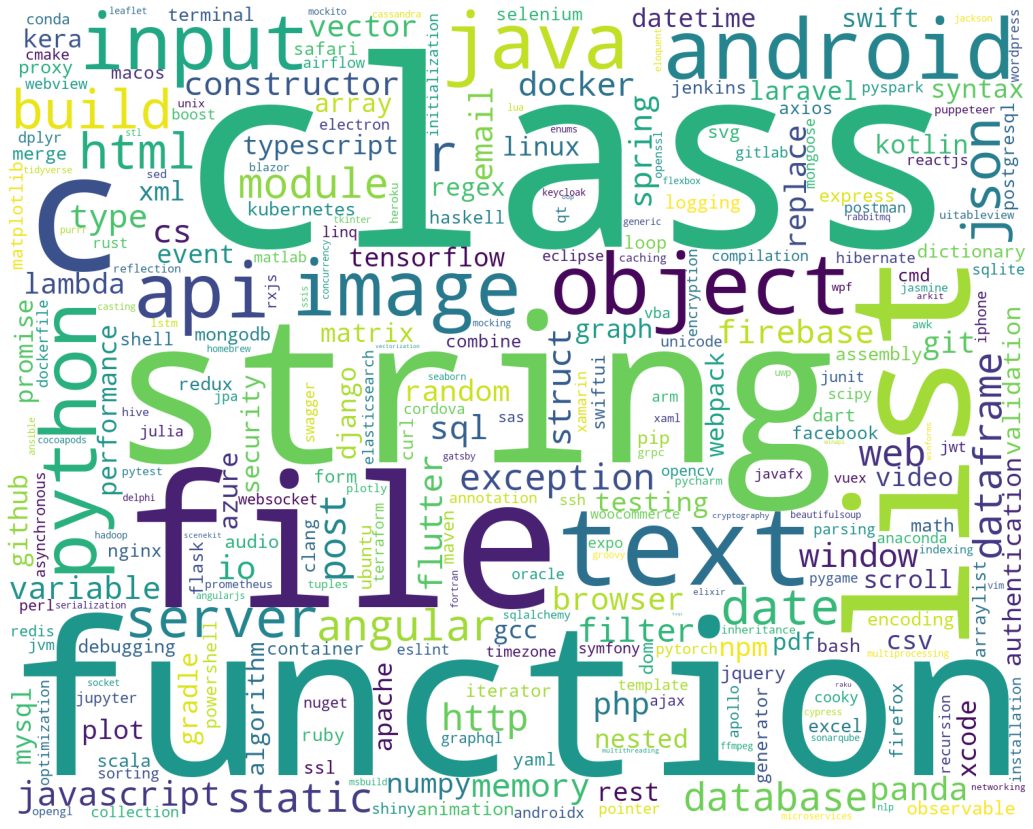

In [87]:
# all below in a single cell
plt.figure(figsize=(20,15))
plt.imshow(w)
plt.axis('off')
plt.savefig('recipes_wordcloud.png')

In [88]:
X_tfidf = pd.DataFrame(X_tfidf)
X_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.137624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.344969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
questions_value = vectorizer.vocabulary_

In [90]:
questions_value_df = pd.DataFrame(questions_value.items(), columns=['word', 'value'])
questions_value_df.head()


,word,value
0,static,250
1,function,93
2,struct,253
3,mongodb,164
4,object,177


In [91]:
word_list = questions_value_df['word'].to_list()
X_tfidf.columns = word_list
X_tfidf.head()

,static,function,struct,mongodb,object,api,date,laravel,post,text,input,kera,module,dataframe,panda,c,list,random,filter,class,html,java,tensorflow,numpy,seaborn,matplotlib,python,logging,csv,validation,iterator,lambda,graph,plot,collection,generator,regex,nginx,php,linux,...,mocking,excel,plotly,shiny,woocommerce,apollo,jasmine,blazor,tuples,xaml,generic,tsql,hive,ssis,vectorization,inheritance,swagger,tkinter,hibernate,winforms,elixir,cypress,hadoop,opengl,nlp,mockito,uwp,lstm,msbuild,keycloak,delphi,ansible,socket,gatsby,oop,cocoapods,winapi,raku,yarnpkg,jestjs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.137624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.344969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
#temp = df_sample_list_st[['Title_Body']]
#X_tfidf = pd.concat([temp, X_tfidf], axis=1)
#X_tfidf.head()

In [93]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=sorted(dict_tag_500.keys()))
df_tags_num = mlb.fit_transform(df_sample_list_st['Tags'])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['.app', '.htaccess', '.net-3.5', '.net-4.0', '.net-4.5', '.net-4.6', '.net-4.6.1', '.net-4.7.1', '.net-4.7.2', '.net-assembly', '.net-attributes', '.net-core-1.1', '.net-core-2.0', '.net-core-2.1', '.net-core-2.2', '.net-core-3.0', '.net-core-3.1', '.net-core-configuration', '.net-core-publishsinglefile', '.net-framework-version', '.net-standard', '.net-standard-2.0', '.net-standard-2.1', '.so', '2-way-object-databinding', '2checkout', '2d', '2d-games', '3-tier', '32-bit', '32bit-64bit', '3d', '3d-model', '3d-secure', '3dcamera', '64-bit', '6502', '68000', '7zip', 'a-star', 'a2dp', 'aac', 'aapt', 'aapt2', 'aar', 'abac', 'abap', 'abc', 'abcl', 'abi', 'abseil', 'absinthe', 'abstract', 'abstract-class', 'abstract-interpretation', 'abstract-syntax-tree', 'abstraction', 'accelerate', 'accelerate-haskell', 'accelerated-mobile-page', 'access-control', 'access-denied', 'access-levels', '

In [94]:
df_tags_num.shape

(40000, 500)

In [95]:
df_tags_num

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [96]:
mlb.classes_

array(['.net', '.net-core', 'aggregation-framework', 'airflow', 'ajax',
       'algorithm', 'amazon-cloudformation', 'amazon-cognito',
       'amazon-dynamodb', 'amazon-ec2', 'amazon-s3',
       'amazon-web-services', 'anaconda', 'android',
       'android-architecture-components', 'android-constraintlayout',
       'android-fragments', 'android-gradle-plugin', 'android-jetpack',
       'android-layout', 'android-livedata', 'android-recyclerview',
       'android-room', 'android-studio', 'androidx', 'angular',
       'angular-cli', 'angular-material', 'angular-material2', 'angular5',
       'angular6', 'angular7', 'angularjs', 'animation', 'annotations',
       'ansible', 'apache', 'apache-kafka', 'apache-spark',
       'apache-spark-sql', 'api', 'apollo', 'arkit', 'arm', 'arraylist',
       'arrays', 'asp.net', 'asp.net-core', 'asp.net-core-2.0',
       'asp.net-core-2.1', 'asp.net-core-mvc', 'asp.net-core-webapi',
       'asp.net-mvc', 'asp.net-web-api', 'assembly', 'async-await',
  

In [99]:
y_tags = pd.DataFrame(df_tags_num, columns=mlb.classes_)
y_tags.head()

,.net,.net-core,aggregation-framework,airflow,ajax,algorithm,amazon-cloudformation,amazon-cognito,amazon-dynamodb,amazon-ec2,amazon-s3,amazon-web-services,anaconda,android,android-architecture-components,android-constraintlayout,android-fragments,android-gradle-plugin,android-jetpack,android-layout,android-livedata,android-recyclerview,android-room,android-studio,androidx,angular,angular-cli,angular-material,angular-material2,angular5,angular6,angular7,angularjs,animation,annotations,ansible,apache,apache-kafka,apache-spark,apache-spark-sql,...,variables,vb.net,vba,vector,vectorization,video,vim,visual-c++,visual-studio,visual-studio-2017,visual-studio-2019,visual-studio-code,vscode-settings,vue-component,vue.js,vuejs2,vuetify.js,vuex,web,web-scraping,webpack,websocket,webview,winapi,windows,windows-10,winforms,woocommerce,wordpress,wpf,x86,xamarin,xamarin.android,xamarin.forms,xaml,xcode,xcode11,xml,yaml,yarnpkg
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# **3.Modelisation**

In [101]:
from sklearn.model_selection import train_test_split

from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### **Train Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_tags,
                                                    test_size=0.3, 
                                                    random_state=random_state)

In [ ]:
X_train.head()

In [ ]:
y_train.head()

### **OneVsRestClass and GridSearchCV**

### **Logistic Regression**

In [ ]:
lr_model = OneVsRestClassifier(LogisticRegression())
lr_hyperparameters = dict(estimator__C=[10**-2, 10**0, 10**2])
lr_cv = GridSearchCV(lr_model, lr_hyperparameters, cv=5, n_jobs = -1, scoring= 'accuracy')

In [ ]:
lr_cv.fit(X_train, y_train)

In [ ]:
lr_cv.best_params_

In [ ]:
lr_cv.score(X_test, y_test)

# **Decision Tree**

In [ ]:
dt_model = Pipeline([('dt', OneVsRestClassifier(estimator = DecisionTreeClassifier()))])
dt_hyperparameters = {'dt__estimator__min_samples_split':[10, 20, 40], 
                   'dt__estimator__min_samples_leaf': [0.05, 0.1, 0.2], 
                   'dt__estimator__criterion':['gini', 'entropy']}

dt_cv = GridSearchCV(dt_model, dt_hyperparameters, scoring='accuracy', cv=5, n_jobs = -1)  

In [ ]:
sorted(dt_model.get_params().keys())

In [ ]:
dt_cv.fit(X_train, y_train)

In [ ]:
dt_cv.best_params_

In [ ]:
dt_cv.score(X_test, y_test)

### **Naive Bayes**

In [ ]:
nb_model = Pipeline([('nb', OneVsRestClassifier(estimator = MultinomialNB()))])
nb_hyperparameters = {'nb__estimator__alpha': [0.01, 0.1, 1]}   

nb_cv = GridSearchCV(nb_model, nb_hyperparameters, scoring='accuracy', cv=5, n_jobs = -1)

In [ ]:
sorted(nb_model.get_params().keys())

In [ ]:
nb_cv.fit(X_train, y_train)

In [ ]:
nb_cv.score(X_test, y_test)

In [ ]:
nb_cv.best_params_

In [ ]:
#X_tfidf.to_csv('X_tfidf_500.csv')
#df_tags_num.to_csv('y_onehot_500.csv')

In [ ]:
questions2 = questions1.apply(tokenize)
questions2

0                                                 [static]
1                             [function, function, struct]
2        [mongodb, object, mongodb, api, date, mongodb,...
3        [laravel, laravel, post, post, text, post, pos...
4        [function, kera, kera, input, module, kera, ke...
                               ...                        
39995                               [multithreading, c, c]
39996    [class, python, class, python, nuget, r, c, mo...
39997    [angular, jasmine, testing, jasmine, testing, ...
39998    [object, python, class, object, c, c, c, c, ob...
39999    [class, static, list, string, static, class, s...
Name: Title_Body, Length: 40000, dtype: object

In [ ]:
wordvec = Word2Vec(questions2, min_count=1)

In [ ]:
print('wordvec:', wordvec)

wordvec: Word2Vec(vocab=302, size=100, alpha=0.025)


In [ ]:
words = list(wordvec.wv.vocab)

In [ ]:
print("\nwords", words)


words ['static', 'function', 'struct', 'mongodb', 'object', 'api', 'date', 'laravel', 'post', 'text', 'input', 'kera', 'module', 'dataframe', 'panda', 'c', 'list', 'random', 'filter', 'class', 'html', 'java', 'tensorflow', 'numpy', 'seaborn', 'matplotlib', 'python', 'logging', 'csv', 'validation', 'iterator', 'lambda', 'graph', 'plot', 'collection', 'generator', 'regex', 'nginx', 'php', 'linux', 'apache', 'android', 'angular', 'form', 'constructor', 'email', 'pytorch', 'image', 'build', 'facebook', 'file', 'pytest', 'cmake', 'github', 'git', 'http', 'variable', 'ubuntu', 'shell', 'gcc', 'type', 'cmd', 'gradle', 'string', 'beautifulsoup', 'animation', 'javascript', 'flutter', 'web', 'database', 'flask', 'terminal', 'server', 'rest', 'mysql', 'array', 'vector', 'terraform', 'azure', 'arm', 'window', 'express', 'exception', 'iphone', 'expo', 'spring', 'elasticsearch', 'merge', 'gitlab', 'ssh', 'performance', 'promise', 'asynchronous', 'json', 'xml', 'browser', 'security', 'vuex', 'nested

In [ ]:
print("\nwordvec['function'] :", wordvec['function'])


wordvec['function'] : [ 0.2206036  -0.57747763  0.41641572  0.65124375  1.4619297  -1.3967032
 -0.56695765 -0.37713003 -0.33544233  1.1699233   0.6872103   0.41166383
 -0.6806787  -1.7766063   0.18949468 -0.11544531 -1.4655269   0.17065762
  1.6106641   1.0720826   1.2865438   0.45993212 -1.3055342  -0.4987406
  0.09162737 -1.2509722  -0.8447279   0.08740783  0.49823627  0.05308268
  0.0836036   0.38553634  1.1000271   1.1210661   0.49962714 -0.778217
 -1.134143   -0.19027309 -0.10574028 -0.5256869   0.35853136 -0.16959962
  0.28645182 -0.3686778  -1.0381397   0.19620277  0.22463927  0.06090628
  0.41588822  0.21738474 -0.1464265  -1.9972532   0.44622713  0.08648917
  0.1537157   0.5171581   0.73939663 -0.26140365 -0.50222516 -0.13418691
 -0.28036267  0.26068982  0.8750205  -0.92699015  0.13559557  0.18430892
  0.13827252  0.04741956 -0.6825563  -0.606343    0.73263764  0.28057295
 -0.5634049  -0.8243794   1.163121   -0.39297608  0.21146974  0.39642304
  1.3129154   0.12357354 -0.4160

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
wordvec.save('wordvec.bin')

In [ ]:
new_wordvec = Word2Vec.load('wordvec.bin')

In [ ]:
print("\nloaded wordvec", new_wordvec)


loaded wordvec Word2Vec(vocab=302, size=100, alpha=0.025)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot

In [ ]:
X = wordvec[wordvec.wv.vocab]
#pca = PCA(n_components=2)
tsne = TSNE(n_components=2)
result = tsne.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


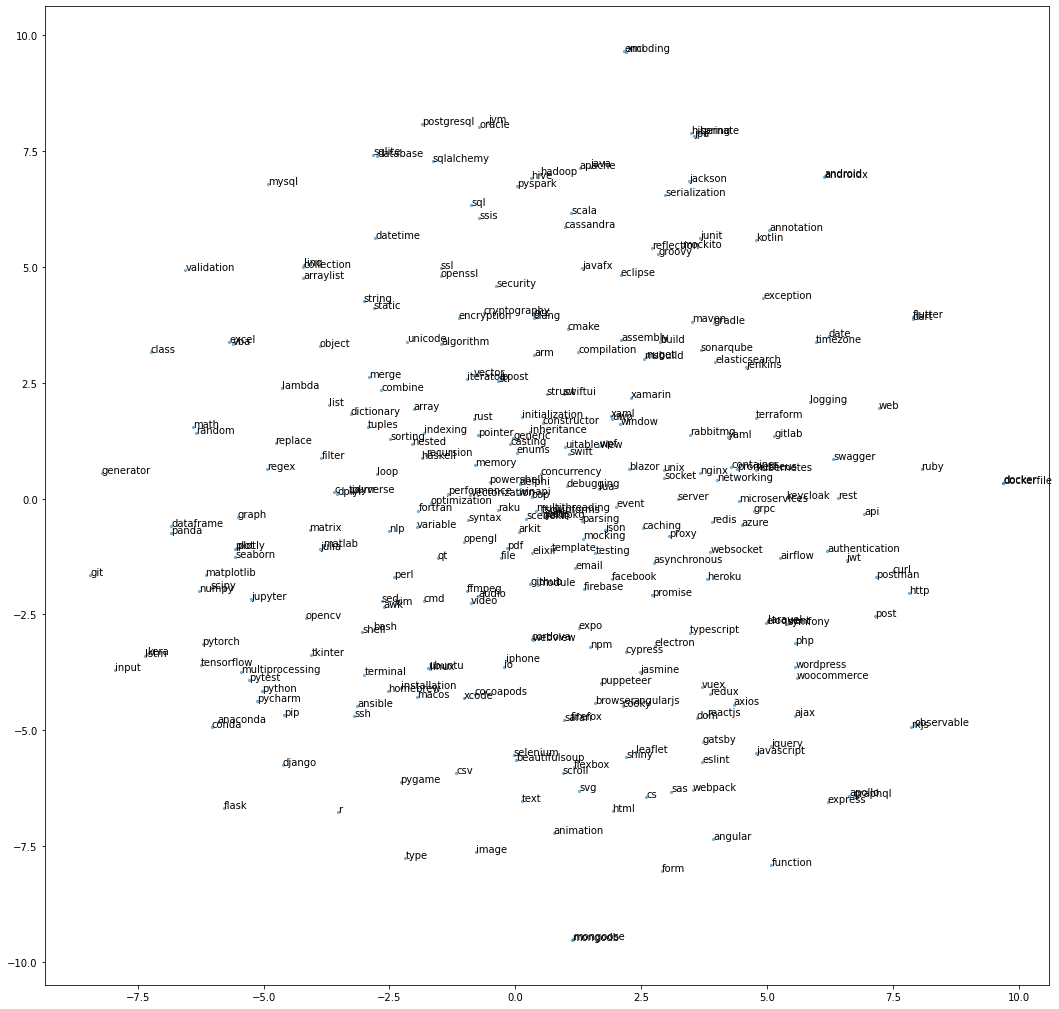

In [ ]:
plt.figure(figsize=(18,18))
pyplot.scatter(result[:, 0], result[:, 1], s=5, alpha=0.5)
for i, word in enumerate(words):
  pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()
